In [1]:
import pandas as pd
import numpy as np

# ===========================
# 1 Cargar y preparar datos
# ===========================
df = pd.read_csv("../data/aptos_bogota_enriched.csv")

# Renombrar columnas calculadas
df = df.drop("estrato", axis=1).rename(columns={
    "estrato_calculado": "estrato",
    "barrio_calculado": "barrio",
    "upz_calculada": "upz"
})

# Eliminar filas sin barrio (necesario para imputar)
df = df[~df['barrio'].isnull()].reset_index(drop=True)

print(f"Registros después de limpieza: {len(df)}")

# ===========================
# 2 Imputación jerárquica
# ===========================
def imputar_por_barrio(df, columna, metodo='media'):
    if metodo == 'media':
        imputacion = df.groupby('barrio')[columna].transform('mean')
    elif metodo == 'moda':
        imputacion = df.groupby('barrio')[columna].transform(
            lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
        )
    df[columna] = df[columna].fillna(imputacion)
    return df

# Variables a imputar
for col, metodo in [
    ('administracion', 'media'),
    ('estado', 'moda'),
    ('upz', 'moda'),
    ('catastral', 'media'),
    ('comercial', 'media'),
    ('antiguedad', 'moda')
]:
    if col in df.columns:
        df = imputar_por_barrio(df, col, metodo)

print("Imputación por barrio completada.")

# ===========================
# 3 Transformación logarítmica
# ===========================
df['precio_venta_log'] = np.log1p(df['precio_venta'])
df['area_log'] = np.log1p(df['area'])

# Confirmación de variables
print("\nColumnas transformadas añadidas:")
print(['precio_venta_log', 'area_log'])

df.head()


Registros después de limpieza: 27214
Imputación por barrio completada.

Columnas transformadas añadidas:
['precio_venta_log', 'area_log']


,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,antiguedad,latitud,longitud,...,parks_and_recreation_2000,infrastructure_services_2000,cultural_amenities_2000,catastral,comercial,upz,barrio,localidad_calculada,precio_venta_log,area_log
0,339000000.0,76.0,3.0,2.0,300000.0,1.0,BRITALIA,ENTRE 10 Y 20 ANOS,4.746592,-74.057571,...,35,165,7,3.227303e+06,3.848904e+06,USAQUEN,SANTA ANA OCCIDENTAL,USAQUEN,19.641511,4.343805
1,440898168.0,54.0,3.0,2.0,305000.0,0.0,LA SABANA,ENTRE 0 Y 5 ANOS,4.607378,-74.082648,...,89,86,1,1.718168e+06,2.144399e+06,EL PRADO,EL PLAN,SUBA,19.904324,4.007333
2,158000000.0,43.0,2.0,2.0,106600.0,0.0,TIBABUYES,ENTRE 10 Y 20 ANOS,4.740109,-74.113675,...,144,85,1,1.627592e+06,2.322134e+06,EL PRADO,MAZUREN,SUBA,18.878106,3.784190
3,222800000.0,48.0,3.0,2.0,151000.0,0.0,VERBENAL,MAS DE 20 ANOS,4.763900,-74.025280,...,40,178,6,3.550046e+06,4.278709e+06,SANTA BARBARA,MOLINOS NORTE,USAQUEN,19.221785,3.891820
4,128900000.0,47.0,2.0,1.0,86500.0,0.0,TINTAL SUR,ENTRE 10 Y 20 ANOS,4.632698,-74.198111,...,39,190,20,3.340397e+06,4.172320e+06,EL REFUGIO,LOS ROSALES,CHAPINERO,18.674547,3.871201


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ===========================
# 4 Definir target y features
# ===========================
target = "precio_venta_log"

# Columnas que no se usarán como predictores
ignore_cols = [
    "precio_venta", "precio_venta_log", "sector",
    "localidad_calculada", "area_log"
]

# Variables predictoras
features = [col for col in df.columns if col not in ignore_cols]

X = df[features].copy()
y = df[target].copy()

# ===========================
# 5 Clasificar variables
# ===========================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

print(f"Variables numéricas: {len(numeric_features)}")
print(f"Variables categóricas: {len(categorical_features)}")

# ===========================
# 6 Preprocesamiento
# ===========================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

print("Preprocesamiento configurado correctamente")


Variables numéricas: 55
Variables categóricas: 4
Preprocesamiento configurado correctamente


In [3]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

# ===========================
# 7 Definir modelos
# ===========================
modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, max_iter=10000),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(
        n_estimators=200, max_depth=None, random_state=42, n_jobs=-1),
    "SVR": SVR(kernel="rbf", C=10, epsilon=0.2),
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
}

# ===========================
# 8 Configurar validación cruzada
# ===========================
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

resultados = []

# ===========================
# 9 Evaluar cada modelo
# ===========================
for nombre, modelo in modelos.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", modelo)])
    print("Evaluando modelo: ", nombre)
    cv_result = cross_validate(
        pipeline, X, y, cv=kf, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    resultados.append({
        "Modelo": nombre,
        "RMSE medio": -np.mean(cv_result["test_RMSE"]),
        "RMSE std": np.std(cv_result["test_RMSE"]),
        "MAE medio": -np.mean(cv_result["test_MAE"]),
        "R² medio": np.mean(cv_result["test_R2"])
    })

# ===========================
# 10 Mostrar resultados ordenados
# ===========================
resultados_df = pd.DataFrame(resultados).sort_values(by="RMSE medio")
print(resultados_df.round(3))


Evaluando modelo:  LinearRegression
Evaluando modelo:  Lasso
Evaluando modelo:  Ridge
Evaluando modelo:  RandomForest
Evaluando modelo:  SVR
Evaluando modelo:  XGBoost
Evaluando modelo:  LightGBM
             Modelo  RMSE medio  RMSE std  MAE medio  R² medio
6          LightGBM       0.170     0.005      0.126     0.956
5           XGBoost       0.170     0.005      0.126     0.956
3      RandomForest       0.178     0.004      0.128     0.952
4               SVR       0.241     0.006      0.182     0.911
2             Ridge       0.279     0.008      0.212     0.881
0  LinearRegression       0.280     0.009      0.212     0.880
1             Lasso       0.337     0.007      0.263     0.827


In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import time

# ===========================
# 1️⃣ Definir espacio de búsqueda
# ===========================

# Espacio para XGBoost
xgb_param_dist = {
    "model__n_estimators": randint(200, 800),
    "model__max_depth": randint(3, 10),
    "model__learning_rate": uniform(0.01, 0.1),
    "model__subsample": uniform(0.7, 0.3),
    "model__colsample_bytree": uniform(0.7, 0.3)
}

# Espacio para LightGBM
lgbm_param_dist = {
    "model__n_estimators": randint(200, 800),
    "model__max_depth": randint(3, 10),
    "model__learning_rate": uniform(0.01, 0.1),
    "model__subsample": uniform(0.7, 0.3),
    "model__colsample_bytree": uniform(0.7, 0.3)
}

param_spaces = {
    "XGBoost": xgb_param_dist,
    "LightGBM": lgbm_param_dist
}

best_results = {}

# ===========================
# 2️⃣ Búsqueda aleatoria
# ===========================
for nombre_modelo, modelo in [("XGBoost", XGBRegressor(random_state=42)), 
                              ("LightGBM", LGBMRegressor(random_state=42))]:

    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", modelo)])
    param_dist = param_spaces[nombre_modelo]

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=25,
        scoring="neg_root_mean_squared_error",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=2
    )

    print(f"\nBuscando mejores parámetros para {nombre_modelo}...")
    inicio = time.time()
    search.fit(X, y)
    duracion = time.time() - inicio

    print(f"Mejor RMSE ({nombre_modelo}): {-search.best_score_:.4f}")
    print(f"Mejores parámetros: {search.best_params_}")
    print(f"Duración: {duracion/60:.1f} minutos")

    best_results[nombre_modelo] = {
        "best_rmse": -search.best_score_,
        "best_params": search.best_params_,
        "search_time_min": round(duracion / 60, 2)
    }

# ===========================
# 3️⃣ Mostrar resumen
# ===========================
results_df = pd.DataFrame(best_results).T
print("\nResultados de optimización:")
print(results_df)



Buscando mejores parámetros para XGBoost...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejor RMSE (XGBoost): 0.1710
Mejores parámetros: {'model__colsample_bytree': np.float64(0.7076257380232285), 'model__learning_rate': np.float64(0.020789142699330444), 'model__max_depth': 9, 'model__n_estimators': 440, 'model__subsample': np.float64(0.794306794322898)}
Duración: 7.8 minutos

Buscando mejores parámetros para LightGBM...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5870
[LightGBM] [Info] Number of data points in the train set: 27214, number of used features: 347
[LightGBM] [Info] Start training from score 20.391700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


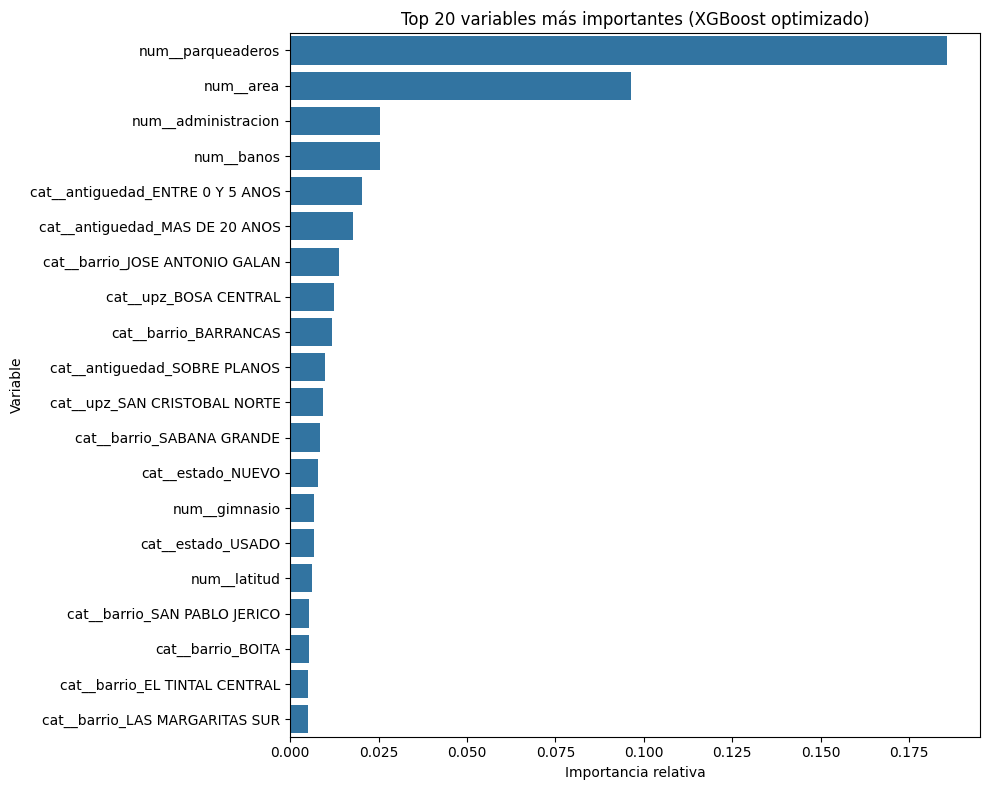

Importancia de variables exportada a feature_importance_xgb.csv


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===========================
# 1️⃣ Entrenar el mejor modelo
# ===========================
best_xgb_params = {
    "colsample_bytree": 0.7076257380232285,
    "learning_rate": 0.049,
    "max_depth": 8,
    "n_estimators": 700,
    "subsample": 0.79,
    "random_state": 42,
    "n_jobs": -1
}

final_model = XGBRegressor(**best_xgb_params)
pipeline_final = Pipeline(steps=[("preprocessor", preprocessor), ("model", final_model)])
pipeline_final.fit(X, y)

# ===========================
# 2️⃣ Obtener nombres de variables
# ===========================
feature_names = pipeline_final.named_steps["preprocessor"].get_feature_names_out()
importances = pipeline_final.named_steps["model"].feature_importances_

# Crear DataFrame de importancia
importance_df = pd.DataFrame({
    "Variable": feature_names,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False)

# ===========================
# 3️⃣ Visualizar top 20 variables
# ===========================
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance_df.head(20),
    x="Importancia",
    y="Variable",
    orient="h"
)
plt.title("Top 20 variables más importantes (XGBoost optimizado)")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# ===========================
# 4️⃣ Guardar resultados
# ===========================
importance_df.to_csv("../data/feature_importance_xgb.csv", index=False)
print("Importancia de variables exportada a feature_importance_xgb.csv")


In [6]:
import numpy as np

def interpretar_rmse_log(rmse_log, df, target_col="precio_venta"):
    """
    Convierte un RMSE calculado sobre el logaritmo del precio en
    error porcentual aproximado y valor en pesos colombianos.

    Parámetros
    ----------
    rmse_log : float
        RMSE obtenido sobre la variable log-transformada.
    df : pandas.DataFrame
        Dataset con la columna original de precios.
    target_col : str
        Nombre de la columna de precio original (en pesos).

    Retorna
    -------
    dict con claves:
        'error_pct'  -> error porcentual aproximado
        'error_pesos' -> error medio estimado en COP
        'precio_medio' -> precio promedio usado como referencia
    """
    precio_medio = df[target_col].mean()
    error_pct = np.exp(rmse_log) - 1
    error_pesos = precio_medio * error_pct

    print(f"RMSE log: {rmse_log:.3f}")
    print(f"Error porcentual aproximado: {error_pct*100:.2f}%")
    print(f"Precio medio: {precio_medio:,.0f} COP")
    print(f"Error promedio estimado: {error_pesos:,.0f} COP")

    return {
        "error_pct": error_pct,
        "error_pesos": error_pesos,
        "precio_medio": precio_medio
    }

# Ejemplo de uso
rmse_log = resultados_df.loc[resultados_df["Modelo"] == "XGBoost", "RMSE medio"].values[0]
interpretar_rmse_log(rmse_log, df, "precio_venta")


RMSE log: 0.170
Error porcentual aproximado: 18.57%
Precio medio: 992,323,529 COP
Error promedio estimado: 184,291,029 COP


{'error_pct': np.float64(0.1857166779157684),
 'error_pesos': np.float64(184291029.30728638),
 'precio_medio': np.float64(992323529.4509811)}